### Что тут вообще происдит

Этот ноутбук появился, когда я вписался в ипотеку. До нее я никогда не платил кредитов с процентами, а только пользовался льготным периодом на кредитке, и поэтому не особо вообще понимал, как устроено начисление процентов. Появился повод разобраться и подумать "вслух". Основной вопрос, который меня волновал, и на который я сходу не нашел ответа в многочисленных кредитных калькуляторах в интернете, звучал так: "А как быстро будет сокращаться ипотечный срок и обязательный платеж, если я буду гасить ипотеку досрочно, и вносить при этом не фиксированную сумму сверху (как сделано в большинстве калькуляторов), а N денег. Бонус вносится на **сокращение обязательного платежа** (не срока ипотеки)" 

### Что происходит в коде

Собственно, ничего сложного. Нам будут нужны две функции - одна будет высчитывать обязательный месячный платеж исходя из суммы долга, процентной ставки и срока кредита - в месяцах или годах. Делает это по упрощённой логике, по месяцам. В реальности банки насчитывают проценты по дням, это не влият на сумму платежа, но влияет на долю процентов в ежемесячном платеже (в зависмости от числа дней в месяце). Вторая функция расчитает нам график платежей в зависимости от того, как будем погашать кредит. График платежей выдает без последнего платежа.
Есть несколько опций. Самая простая - не трогать параметры monthlyPayment и extraCash - тогда мы получим "обычный" грфик платежей. Можно задать число  extraCash > 0 и получить расчет для досрочного погашения каждый месяц на фиксированную дополнительную сумму (напоминаю, здесь мы считаем, что всё сверху идет на сокращение обязательного платежа). И, наконец, последний вариант, самый интересный - получить график платежей при условии, что мы сокращаем ежемесячный платеж, но все равно продолжаем платить фиксированную сумму. В параметр monthlyPayment указываем, какую именно. 

Полученную информацию мы потом выводим на графики и наглядно видим, как работают разные стратегии досрочного погашения

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
#no scientific notation in data frames please
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
def monthly_payment_calc(creditAmount, yearlyInterestRate, period, useYears=True):
    '''
    Simplified version of monthly mortgage calculator
    !Real banks will use daily interst rate instead of monthly!
    useYears - if True, trats period as years, months otherwise
    '''
    monthlyInterstRate = yearlyInterestRate/12
    if useYears:
        monthPeriod = period * 12
    else: 
        monthPeriod = period
    monthlyPayment = ( creditAmount * 
                    (monthlyInterstRate/(1 - (1 + monthlyInterstRate)**(-monthPeriod))) )
    return monthlyPayment

In [5]:
def payment_graph_calc(monthlyPayment = 'default', creditAmount=1000000, yearlyInterestRate=10, yearPeriod=10, extraCash = 0):
    '''
    produces data frame with monthly payments
    '''
    if monthlyPayment == 'default':
        mp = True
        monthlyPayment = monthly_payment_calc(creditAmount, yearlyInterestRate, yearPeriod)
    else:
        mp = False
    monthlyInterstRate = yearlyInterestRate/12
    monthPeriod = yearPeriod * 12
    columnNames = ['MonthlyPayment','MonthlyPaymentObligatory', 'InterestPart', 'CreditPart', 'Remainder']
    payment = pd.DataFrame(index = range(1,monthPeriod+1), columns = columnNames)
    payment.loc[:, 'MonthlyPayment'] = monthlyPayment + extraCash
    payment.loc[1, 'InterestPart'] = creditAmount * monthlyInterstRate
    payment.loc[1, 'CreditPart'] = payment.loc[1, 'MonthlyPayment'] - payment.loc[1, 'InterestPart']
    payment.loc[1, 'Remainder'] = creditAmount + payment.loc[1, 'InterestPart'] - payment.loc[1, 'MonthlyPayment']
    payment.loc[1, 'MonthlyPaymentObligatory'] = monthly_payment_calc(creditAmount, yearlyInterestRate, 
                                                                      monthPeriod, useYears=False)
    
    for i in range(2, len(payment.index)+1):
        payment.loc[i, 'MonthlyPaymentObligatory'] = monthly_payment_calc(payment.Remainder[i-1], yearlyInterestRate, 
                                                                          monthPeriod - i + 1,useYears=False)
        if mp:
            payment.loc[i:, 'MonthlyPayment'] = payment.loc[i, 'MonthlyPaymentObligatory'] + extraCash
        payment.loc[i, 'InterestPart'] = payment.loc[i-1, 'Remainder'] * monthlyInterstRate
        payment.loc[i, 'CreditPart'] = payment.loc[i, 'MonthlyPayment'] - payment.loc[i, 'InterestPart']
        payment.loc[i, 'Remainder'] = payment.Remainder[i-1] + payment.InterestPart[i] - payment.MonthlyPayment[i]
    return payment[payment.Remainder >= 0]

Функции задали, давайте теперь посмотрим, как они работают! Начнем с простого, рассчитаем ежемесячный платеж для ипотеки в 6 000 000 с проценной ставкой в 8 процентов годовых и сроком в 15 лет. Это функция monthly_payment_calc

In [6]:
amount = 6000000
interest = 0.08
period = 15

In [7]:
monthly_payments = monthly_payment_calc(amount, interest, period, useYears=True)
print(monthly_payments)

57339.12505982139


Можно ту же самую операцию повторить и с месячным сроком, главное не забыть выставить параметр useYears в False. Вот какой расчет будет для 14.5 лет (172 месяцев):

In [8]:
monthly_payment_calc(amount, interest, 172, useYears=False)

58728.977175195294

Можно чуть-чуть поколдовать и посмотреть, как ежемесячный платеж будет меняться в зависимости от процентной ставки. dec_monthly - функция-декоратор, в которую удобно подсовывать разные значения процентной ставки про неизменных сумме и сроке. Посмотрим, как будет меняться ежемесячный платеж на разных процентных ставках, от 7.5% до 10%:

In [9]:
def dec_monthly(x):
    return monthly_payment_calc(amount,x,period)

In [10]:
rates = np.round(np.arange(0.075,0.1,0.001),3) #список процентных ставок с шагом в 0.1%; round для удаления артефактов

In [11]:
list(zip(list(map(dec_monthly,rates)),rates))

[(55620.741600163856, 0.075),
 (55962.24610269144, 0.076),
 (56304.84047095689, 0.077),
 (56648.52094956618, 0.078),
 (56993.28375173694, 0.079),
 (57339.12505982139, 0.08),
 (57686.04102581479, 0.081),
 (58034.02777188148, 0.082),
 (58383.081390866624, 0.083),
 (58733.19794682501, 0.084),
 (59084.37347553561, 0.085),
 (59436.603985031645, 0.086),
 (59789.88545612213, 0.087),
 (60144.213842914374, 0.088),
 (60499.58507334648, 0.089),
 (60855.995049706864, 0.09),
 (61213.439649168366, 0.091),
 (61571.914724309085, 0.092),
 (61931.41610364704, 0.093),
 (62291.93959216146, 0.094),
 (62653.48097182753, 0.095),
 (63016.03600213781, 0.096),
 (63379.600420635834, 0.097),
 (63744.16994344108, 0.098),
 (64109.7402657738, 0.099),
 (64476.307062487074, 0.1)]

При процентной ставке в 7.5% ежемесячный платеж будет 55620, а при 10% - 64476. Разница вроде бы и невелика, но вот ниже будет видно, насколько быстрее можно будет расправиться с кредитом по ставке в 7.5%, если платить каждый месяц чуть больше, хоть бы и те же 64476. 

установим ставку на 7.5%, cумму и срок оставим прежними, 6 000 000 и 15 лет соответственно:

In [12]:
amount = 6000000
interest = 0.075
period = 15

In [13]:
df_no_extra = payment_graph_calc(creditAmount=amount, yearlyInterestRate=interest,yearPeriod=period)

Посмотрим сначала на кредитный график без досрочных погащений:

In [14]:
df_no_extra.head()

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
1,55620.742,55620.742,37500.000,18120.742,5981879.258
2,55620.742,55620.742,37386.745,18233.996,5963645.262
3,55620.742,55620.742,37272.783,18347.959,5945297.303
4,55620.742,55620.742,37158.108,18462.633,5926834.670
5,55620.742,55620.742,37042.717,18578.025,5908256.645


In [15]:
df_no_extra.tail() #хвост

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
176,55620.742,55620.742,1706.027,53914.714,219049.653
177,55620.742,55620.742,1369.060,54251.681,164797.972
178,55620.742,55620.742,1029.987,54590.754,110207.218
179,55620.742,55620.742,688.795,54931.946,55275.271
180,55620.742,55620.742,345.470,55275.271,0.000


Платить будем все 15 лет, общая переплата составит чуть больще 4 000 000

In [16]:
df_no_extra['InterestPart'].sum()

4011733.4880295894

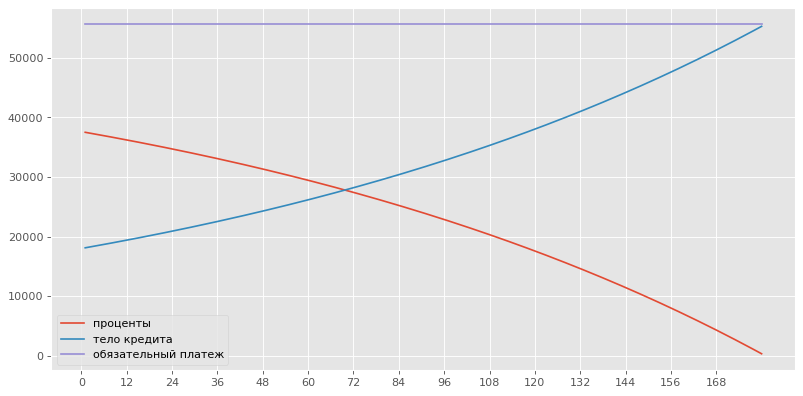

In [17]:
df1 = df_no_extra.copy()
plt.figure(figsize=(12, 6), dpi=80)
plt.style.use('ggplot')
plt.xticks(np.arange(0, period*12, step=12))
plt.plot(df1.index, df1.InterestPart, df1.CreditPart)
plt.plot(df1.index, df1.MonthlyPaymentObligatory)
plt.legend(['проценты', 'тело кредита', 'обязательный платеж'])

На графике - ожидаемая картина. Доля процентов в платеже плавно сокращается, а доля основного долга - так же плавно растёт. Сам обязательный платеж (мы же не платим вперед!) во времени не меняется, а график растянут на 180 месяцев (15 лет).
Площадь под красной линией - сумма переплаты. В наших интересах ее сокращать - и путём изменения основания (платить меньше), и путем изменения формы - чтобы линия была выгнута вниз

Давайте теперь нарисуем такие же картиночки, но для дополнительных 10000 в месяц

In [18]:
df_extra_10 = payment_graph_calc(creditAmount=amount, yearlyInterestRate=interest,yearPeriod=period, extraCash=10000)

Посмотрим первые и последние строки графика. Срок не изменился, а вот сумма платежа (MonthlyPayment) под конец изрядно похудела...

In [19]:
df_extra_10.head()

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
1,65620.742,55620.742,37500.000,28120.742,5971879.258
2,65527.760,55527.760,37324.245,28203.514,5943675.744
3,65434.493,55434.493,37147.973,28286.520,5915389.224
4,65340.939,55340.939,36971.183,28369.756,5887019.468
5,65247.093,55247.093,36793.872,28453.222,5858566.246


In [20]:
df_extra_10.tail()

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
174,26420.252,16420.252,700.758,25719.494,86401.773
175,24716.937,14716.937,540.011,24176.926,62224.847
176,22679.282,12679.282,388.905,22290.376,39934.470
177,20140.098,10140.098,249.590,19890.507,20043.963
178,16765.011,6765.011,125.275,16639.736,3404.227


Платить будем все те же 15 лет, общая переплата составит чуть больше 3 440 000

In [21]:
df_extra_10['InterestPart'].sum()

3440945.232278041

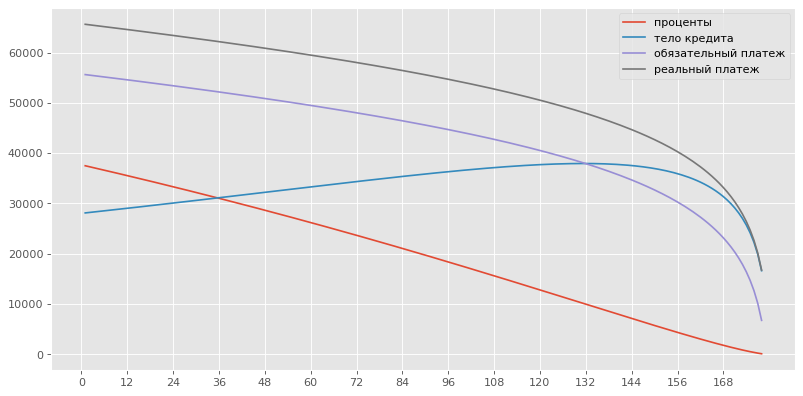

In [22]:
df1 = df_extra_10.copy()
plt.figure(figsize=(12, 6), dpi=80)
plt.style.use('ggplot')
plt.xticks(np.arange(0, period*12, step=12))
plt.plot(df1.index, df1.InterestPart, df1.CreditPart)
plt.plot(df1.index, df1.MonthlyPaymentObligatory, df1.MonthlyPayment)
plt.legend(['проценты', 'тело кредита', 'обязательный платеж', 'реальный платеж'])

При таком раскладе получилось немного сэкономить, а заодно и подстраховаться на случай неприятных перемен - дополнительные 10К резво снижают обязательный платеж. Если доход вдруг резко сократиться, то платить обязательной части придется меньше. 

А что будет, если мы будем гасить кредит более активно, и всю "экономию", полученную от сокрщения ежемесячного платежа, пустим туда же? 
Посмотрим, как изменится картина, если мы начнем наш 7.5% кредит платежом в 64476 (как если бы ставка была 10%)

In [23]:
df_all_in = payment_graph_calc(monthlyPayment=64476, creditAmount=amount, yearlyInterestRate=interest,yearPeriod=period)

Опа! график обрывается на 140 месяце, то есть кредит при таком подходе выплачен досрочно, менее чем за 12 лет

In [24]:
df_all_in.head()

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
1,64476,55620.742,37500.000,26976.000,5973024.000
2,64476,55538.404,37331.400,27144.600,5945879.400
3,64476,55455.046,37161.746,27314.254,5918565.146
4,64476,55370.651,36991.032,27484.968,5891080.178
5,64476,55285.201,36819.251,27656.749,5863423.430


In [25]:
df_all_in.tail()

,MonthlyPayment,MonthlyPaymentObligatory,InterestPart,CreditPart,Remainder
135,64476,9261.723,2307.947,62168.053,307103.487
136,64476,7850.312,1919.397,62556.603,244546.884
137,64476,6374.317,1528.418,62947.582,181599.302
138,64476,4829.231,1134.996,63341.004,118258.298
139,64476,3210.120,739.114,63736.886,54521.412


Общая переплата еще меньше, около 3017000

In [26]:
df_all_in['InterestPart'].sum()

3016685.4121447774

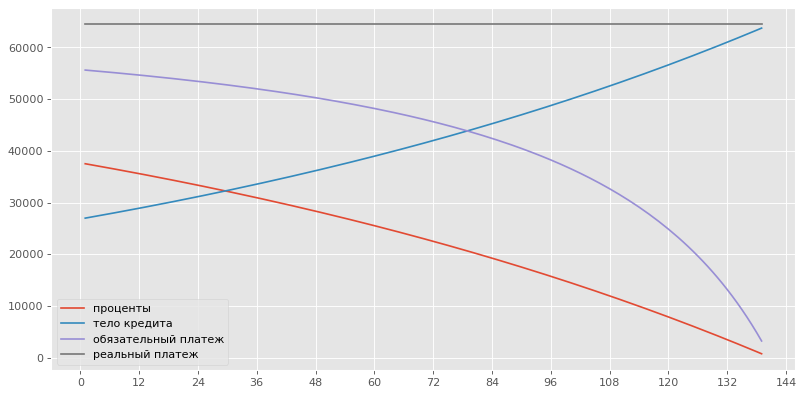

In [27]:
df1 = df_all_in.copy()
plt.figure(figsize=(12, 6), dpi=80)
plt.style.use('ggplot')
plt.xticks(np.arange(0, period*12, step=12))
plt.plot(df1.index, df1.InterestPart, df1.CreditPart)
plt.plot(df1.index, df1.MonthlyPaymentObligatory, df1.MonthlyPayment)
plt.legend(['проценты', 'тело кредита', 'обязательный платеж', 'реальный платеж'])

Итак, если каждый месяц вносить одну и ту же сумму, направляя излишки на сокращение обязательного платежа, ипотеку мы выплатим за менее чем 12 лет, вместо ожидаемых 15. И в этом конкретном случае заплатим три миллиона рублей процентов, вместо четырёх, переплата сократится на 30%!

А что будет, если мы ту же дополнительную сумму будем вносить на сокращение срока кредита? Давайте посчитаем. Тут я восрользовался [сторонним сервисом](https://calcus.ru/kreditnyj-kalkulyator-s-dosrochnym-pogasheniem?result=157005), благо такой расчёт умеют делать почти все онлайн-калькуляторы. 

Если в нашу гипотетическую ипотеку на 6 миллионов под 7.5% вкидывать каждый месяц по 64 476 рублей, то мы получим... Те же самые 140 месяцев и три миллиона процентов вместо четырёх! 

То есть при одинаковой сумме платежа, оба варианта (уменьшение платежа, уменьшение срока) досрочного погашения сводятся к одинаковой длительности и одинаковой переплате! Любопытно, что при этом каждый калькулятор считаем своим долгом сообщить пользователю, что выгоднее сокращать срок кредита. Я понимаю, из каких расчётов они показывают эту "выгоду". Но считаю, что её уж очень сложно почувствовать - большую часть кредита мне, как плательщику, глубоко пофигу, сколько там лет осталось платить - всё таки 10 или уже 9. А вот текущий размер обязательного платежа сказывается на моей реальности намного сильнее - в жизни бывают не только белые полосы, но и чёрные. И прилично сократившийся обязательный платеж в такие моменты будет как нельзя кстати - на графике выше видно, что через 4 года обязательный платеж уде меньше 50К, а через 7 становится меньше 40К. Такую выгоду от своих действий ощущать намного приятнее, чем эфемерное знание, что платить тебе **ту же самую** сумму нужно ещё не 7 лет, а 5. 

У меня на этом всё, надеюсь, вам было полезно, и вы узнали для себя что-то новое. Уж я так точно узнал. И картинки порисовал, и таблички попрограммировал, и грамотность финансовую прокачал! 